## Making Models

This is a notebook that contains an example from the board game risk. 
We will be using the brent API to generate the right `DAG` for the situation. 

The `DAG` in question generalises a scenario in the RISK board game. In this game
typically three armies attack and two defend. The highest scoring attacker
(based on a dice roll) is matched with the highest scoring defender, the second
highest attacker goes with the second highest defender and so on. The defending
party has the advantage so the attacker needs to roll higher than the defender
in order to win. The `losses` node in the graph corresponds to the losses
that the defender incurs during the battle.

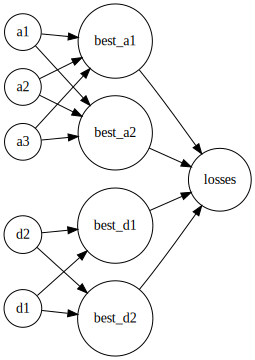

In [1]:
from pprint import pprint
from brent import DAG, Query 
from brent.examples import generate_risk_dag

dag = generate_risk_dag(attackers=3, defenders=2, battle_size=2)
dag.plot()

The base dag has a few nodes: 

- `a1, a2, a3` denote the dice rolls of the attacking party
- `d1, d2` denote the dice rolls of the defending party
- `best_ij` denotes the best/second best roll of either the defender or attacker 
- `losses` denotes the losses incurred after the battle

With such a system we can ask questions like "given that none of the armies lost, what dice-rolls are likely?" 

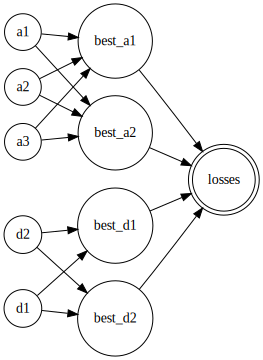

In [2]:
q = Query(dag).given(losses=0)
q.plot()

In [3]:
pprint(q.infer())

{'a1': {1: 0.2553846153846177,
        2: 0.22857142857143034,
        3: 0.19076923076923172,
        4: 0.15076923076923085,
        5: 0.11032967032967,
        6: 0.0641758241758243},
 'a2': {1: 0.2553846153846177,
        2: 0.22857142857143034,
        3: 0.19076923076923172,
        4: 0.15076923076923085,
        5: 0.11032967032967,
        6: 0.0641758241758243},
 'a3': {1: 0.2553846153846177,
        2: 0.22857142857143034,
        3: 0.19076923076923172,
        4: 0.15076923076923085,
        5: 0.11032967032967,
        6: 0.0641758241758243},
 'best_a1': {1: 0.01582417582417581,
             2: 0.09010989010988998,
             3: 0.18637362637362723,
             4: 0.2571428571428595,
             5: 0.26549450549450804,
             6: 0.18505494505494588},
 'best_a2': {1: 0.1806593406593414,
             2: 0.3208791208791246,
             3: 0.2734065934065961,
             4: 0.15956043956043983,
             5: 0.05846153846153858,
             6: 0.00703296703296

In general we see that it is likely that the defending party had high dice rolls while the attacking party probably had lower dicerolls. 

## More Complex Queries 

The queries can also get relatively complex. Suppose now that we know that an attacker trew a six while the defender threw a 5. We also know that the second best dice that was rolled by the defender was a 5. How likely are all the other outcomes?

This somewhat complex query is easy to run in our graphical setting.

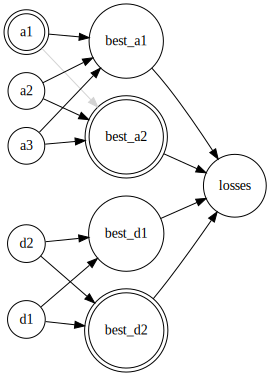

In [4]:
q = Query(dag).given(a1=6, best_d2=5, best_a2=5)
q.plot()

In [5]:
pprint(q.infer())

{'a1': {6: 1.0000000000000007},
 'a2': {1: 0.11111111111111113,
        2: 0.11111111111111113,
        3: 0.11111111111111113,
        4: 0.11111111111111113,
        5: 0.5555555555555557,
        6: 0.0},
 'a3': {1: 0.11111111111111113,
        2: 0.11111111111111113,
        3: 0.11111111111111113,
        4: 0.11111111111111113,
        5: 0.5555555555555557,
        6: 0.0},
 'best_a1': {5: 0.0, 6: 1.0000000000000007},
 'best_a2': {5: 1.0000000000000007},
 'best_d1': {5: 0.33333333333333337, 6: 0.666666666666667},
 'best_d2': {5: 1.0000000000000007},
 'd1': {1: 0.0,
        2: 0.0,
        3: 0.0,
        4: 0.0,
        5: 0.666666666666667,
        6: 0.33333333333333337},
 'd2': {1: 0.0,
        2: 0.0,
        3: 0.0,
        4: 0.0,
        5: 0.666666666666667,
        6: 0.33333333333333337},
 'losses': {0: 0.666666666666667, 1: 0.33333333333333337}}


## Confirming Logic 

Some things that we know from this query: 

- We know that there are no losses even though the attacker rolled a six. This means that one of the dicerolls from the defender needs to be a six. 
- We know that the second best roll for the attacker was a 5 and we know that the best roll was a 6. 

We can confirm from the queries that these two properties hold.

In [6]:
tbl = q.infer(give_table=True)

In [7]:
tbl.groupby(['d1', 'd2'])['prob'].sum(skipna=True).reset_index().loc[lambda d: d['prob'] > 0.0001]

,d1,d2,prob
28,5,5,0.333333
29,5,6,0.333333
34,6,5,0.333333


In [8]:
tbl.groupby(['a1', 'a2', 'a3'])['prob'].sum(skipna=True).reset_index().loc[lambda d: d['prob'] > 0.0001]

,a1,a2,a3,prob
4,6,1,5,0.111111
10,6,2,5,0.111111
16,6,3,5,0.111111
22,6,4,5,0.111111
24,6,5,1,0.111111
25,6,5,2,0.111111
26,6,5,3,0.111111
27,6,5,4,0.111111
28,6,5,5,0.111111


The effect of the losses can also be confirmed to work.

In [9]:
tbl.groupby(['losses'])['prob'].sum(skipna=True).reset_index().loc[lambda d: d['prob'] > 0.0001]

,losses,prob
0,0,0.666667
1,1,0.333333


# CounterFactual Query 

Let's now ask another counterfactual question. Suppose that we see that the defender did not lose any armies. Would the result have been different if the first roll of the attacker was a six?

In [10]:
from brent import SupposeQuery
q = Query(dag).given(losses=0)
sq = SupposeQuery(dag).when(q).suppose_given(a1=6)

In [11]:
pprint(sq.infer())

{'a1': {6: 0.9999999999999999},
 'a2': {1: 0.4066173136228913,
        2: 0.30546317952640056,
        3: 0.18097228188266729,
        4: 0.08189653648116535,
        5: 0.02344384152596513,
        6: 0.001606846960910561},
 'a3': {1: 0.40661731362289133,
        2: 0.30546317952640056,
        3: 0.18097228188266726,
        4: 0.08189653648116535,
        5: 0.023443841525965126,
        6: 0.001606846960910561},
 'best_a1': {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.9999999999999999},
 'best_a2': {1: 0.19759588409936557,
             2: 0.3427319665728046,
             3: 0.27118862830898394,
             4: 0.1415828583781874,
             5: 0.043790089446878344,
             6: 0.0031105731937802698},
 'best_d1': {1: 2.6014916467229946e-08,
             2: 1.9893679636289427e-05,
             3: 0.00104774968051354,
             4: 0.016624981256521246,
             5: 0.14016474749084637,
             6: 0.8421426018775661},
 'best_d2': {1: 0.00035820346560850355,
          